### This jupyter notebooks provides the code for classifying signals using the Discrete Wavelet Transform.
### To get some more background information, please have a look at the accompanying blog-post:
### http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [1]:
import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from IPython.display import display

import matplotlib.pyplot as plt
import pywt
import scipy.stats

import datetime as dt
from collections import defaultdict, Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

In [2]:
dict_classifiers = {
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Linear SVM": SVC(),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),   
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian Process": GaussianProcessClassifier()
}
   
def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models

def get_train_test(df, y_col, x_cols, ratio):
    """ 
    This method transforms a dataframe into a train and test set, for this you need to specify:
    1. the ratio train : test (usually 0.7)
    2. the column with the Y_values
    """
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
       
    Y_train = df_train[y_col].values
    Y_test = df_test[y_col].values
    X_train = df_train[x_cols].values
    X_test = df_test[x_cols].values
    return df_train, df_test, X_train, Y_train, X_test, Y_test
    
def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))
    
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_uci_har_features(dataset, labels, waveletname):
    uci_har_features = []
    for signal_no in range(0, len(dataset)):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            list_coeff = pywt.wavedec(signal, waveletname)
            for coeff in list_coeff:
                features += get_features(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    Y = np.array(labels)
    return X, Y

# 1. Loading the UCI HAR dataset
download dataset from https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [11]:
os.listdir("../../data/UCI HAR Dataset/train/Inertial Signals")

['body_acc_x_train.txt',
 'body_acc_y_train.txt',
 'body_acc_z_train.txt',
 'body_gyro_x_train.txt',
 'body_gyro_y_train.txt',
 'body_gyro_z_train.txt',
 'total_acc_x_train.txt',
 'total_acc_y_train.txt',
 'total_acc_z_train.txt']

In [13]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

INPUT_FOLDER_TRAIN = "../../data/UCI HAR Dataset/train/Inertial Signals/"
INPUT_FOLDER_TEST = "../../data/UCI HAR Dataset/test/Inertial Signals/"

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = '../../data/UCI HAR Dataset/train/y_train.txt'
LABELFILE_TEST = '../../data/UCI HAR Dataset/test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(train_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 7352 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({6: 537, 5: 532, 1: 496, 4: 491, 2: 471, 3: 420})


# 2. Generating features for the UCI-HAR features

In [101]:
def plot_frequency_subbands(signal, wavelet_coeff):

    n_plots = len(wavelet_coeff) +1 

    fig, axarr = plt.subplots(nrows=n_plots , ncols=1, figsize=(6,8))

    ii = 0
    axarr[ii].set_title("Original Signal", fontsize=8)
    axarr[ii].set_ylabel("Original Signal", fontsize=8, rotation=90)
    axarr[ii].plot(signal, 'b')
    axarr[ii].set_yticklabels([])

    for ii in range(1 , n_plots ):
        if ii == 1:
            axarr[ii].set_title("Frequency Subbands", fontsize=8)
            axarr[ii].set_ylabel("Aprox. {}".format(ii), fontsize=8, rotation=90)
            axarr[ii].plot(wavelet_coeff[ii -1], 'r')
            axarr[ii].set_yticklabels([])
        else:
            axarr[ii].set_ylabel("Detail {}".format(ii -1), fontsize=8, rotation=90)
            axarr[ii].plot(wavelet_coeff[ii -1], 'g')
            axarr[ii].set_yticklabels([])
        
    plt.tight_layout()
    plt.show()


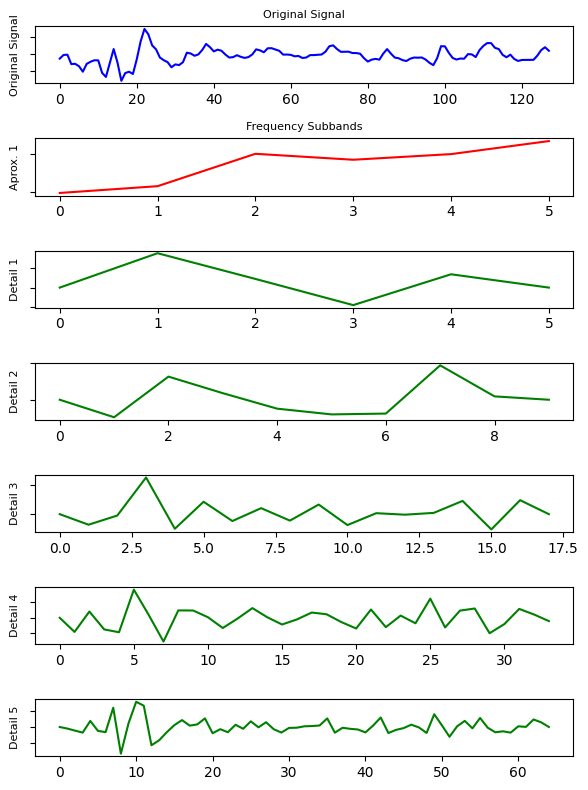

In [102]:
ts = uci_har_signals_train[0,:,0]
waveletname = 'rbio3.1' #'db2'
coeff = pywt.wavedec(ts, waveletname)
# for x in list_coeff:
#     print(len(x))

plot_frequency_subbands(signal = ts, 
                        wavelet_coeff = coeff)


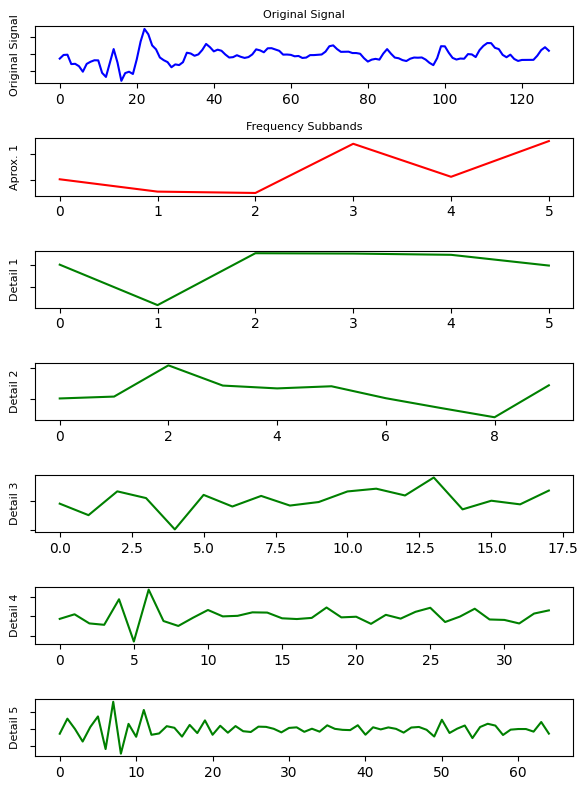

In [98]:
ts = uci_har_signals_train[0,:,0]
waveletname = 'db2'
coeff = pywt.wavedec(ts, waveletname)
# for x in list_coeff:
#     print(len(x))

plot_frequency_subbands(signal = ts, 
                        wavelet_coeff = coeff)

## Features 

- 9 Timeseries (Channels) per Sample
- 128 data points per timeseries
- 648 Features
    - 648 / 9 Channels = 72 Features per Channel
    - 648 / 12 Features / 9 Channels  = 6 Wavelet Coefficient Levels

**Features per Channel**

- Using Reverse Biorthogonal 3.1
- When applying Wavelet Decomposition to a Discrete Signal of 128 Sample we get 6 coefficients (1) approximation and (5) detail coefficients. 
- Features Extraction: 
    - (1) Entropy
    - (2) Percentile 5
    - (3) Percentile 25
    - (4) Percentile 75
    - (5) Percentile 95
    - (6) median
    - (7) mean 
    - (8) std
    - (9) var
    - (10) rms
    - (11) number of zero crossing
    - (12) number of average crossings


<img src = 'Feature_Generation_Wavelet.PNG' width="900" height="550">

In [14]:
waveletname = 'rbio3.1'
X_train, Y_train = get_uci_har_features(uci_har_signals_train, uci_har_labels_train, waveletname)
X_test, Y_test = get_uci_har_features(uci_har_signals_test, uci_har_labels_test, waveletname)

In [19]:
X_train.shape

(7352, 648)

# 3. Classifying the train and test sets

In [4]:
models = batch_classify(X_train, Y_train, X_test, Y_test)
display_dict_models(models)

trained Gradient Boosting Classifier in 398.44 s
trained Random Forest in 1.47 s
trained Logistic Regression in 22.68 s
trained Nearest Neighbors in 0.63 s
trained Decision Tree in 7.32 s


,classifier,train_score,test_score,train_time
0,Gradient Boosting Classifier,1.000000,0.949101,398.442859
2,Logistic Regression,0.980277,0.932134,22.677510
1,Random Forest,0.999320,0.900916,1.468736
4,Decision Tree,1.000000,0.850017,7.320323
3,Nearest Neighbors,0.954570,0.838480,0.626256
